# Exploratory Data Analysis 

This notebook serves to find strong predictors, correlations and dependencies between the available data

## 0. Import Dependencies

In [268]:
import pandas as pd
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#!pip install plotly
import plotly.express as px 

from IPython.display import display

In [269]:
SEED = 42
np.random.seed(SEED)

In [270]:
BASE_DIR = Path(r"C:/Users/black/Documents/Ironhack/final_project")
RAW_DIR = BASE_DIR / "data" / "raw"
CLEAN_DIR = BASE_DIR / "data" / "clean"
PROCESSED_DIR = BASE_DIR / "data" / "processed"
FEATENG_DIR = BASE_DIR / "data" / "feat_eng"

RAW_DIR.mkdir(parents=True, exist_ok=True)
CLEAN_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
FEATENG_DIR.mkdir(parents=True, exist_ok=True)

## 1. Plot Settings

In [271]:
# seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

# matplotlib general settings
plt.rcParams['figure.figsize'] = (5, 3)  # default figure size
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['grid.alpha'] = 0.3

In [272]:
# reproducibility
RANDOM_STATE = SEED

In [273]:
# custom color palette
colors = {
    'rosa': '#F4A3B8',     
    'pink': '#FF69B4',     
    'orange': '#FFA500',   
    'yellow': '#FFD700',   
    'red': '#FF4500',      
    'lilac': '#C8A2C8',    
}

sns.set_palette(list(colors.values()))

In [274]:
# display
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:.2f}'.format)

## 2. Load Data 

In [275]:
# directory datasets
PROCESSED_DIR = Path(r"C:\Users\black\Documents\Ironhack\final_project\data\processed")

# dataset names list 
dataset_name = [
    "domestic",
    "vawg",
    "freedom",
    "danger",
    "gdp",
    "wage_gap",
    "unemployment",
    "gii",
    "legal",
    "partner_violence",
    "eq_laws",
    "wpsi",
    "master_country_table"
]

# helper function loading all dfs
def load_all_datasets(dataset_names, path=PROCESSED_DIR):
    datasets = {}
    for name in dataset_names:
        file_path = path / f"{name}.csv"
        try:
            df = pd.read_csv(file_path)
            datasets[name] = df
            print(f"Loaded: {name} ({df.shape[0]} rows, {df.shape[1]} cols)")
        except FileNotFoundError:
            print(f"Warning: {file_path} not found.")
    return datasets

# load all datasets
datasets = load_all_datasets(dataset_name)

# individual dataset
dv_df = datasets["domestic"]
vawg_df = datasets["vawg"]
gdp_df = datasets["gdp"]
hfi_df = datasets["freedom"]
mdc_df = datasets["danger"]
gwg_df = datasets["wage_gap"]
gud_df = datasets["unemployment"]
gii_df = datasets["gii"]
lf_df = datasets["legal"]
aip_df = datasets["partner_violence"]
gel_df = datasets["eq_laws"]
wpsi_df = datasets["wpsi"]
master_country_df = datasets["master_country_table"]

Loaded: domestic (347 rows, 6 cols)
Loaded: vawg (415 rows, 19 cols)
Loaded: freedom (165 rows, 6 cols)
Loaded: danger (50 rows, 9 cols)
Loaded: gdp (195 rows, 3 cols)
Loaded: wage_gap (43 rows, 2 cols)
Loaded: unemployment (1134 rows, 5 cols)
Loaded: gii (195 rows, 13 cols)
Loaded: legal (127 rows, 3 cols)
Loaded: partner_violence (151 rows, 3 cols)
Loaded: eq_laws (7 rows, 8 cols)
Loaded: wpsi (176 rows, 3 cols)
Loaded: master_country_table (195 rows, 30 cols)


## 3. Individual-Level Analysis

### 3.1 Domestic Dataset

#### 3.1.1 Univariate Analysis

**Key Questions**
- age distribution: certain age groups overrepresented?
- income distribution: is it skewed? any extreme values?
- Education/Employment/Marital Status: What are the category frequencies?
- Violence rate: What's the baseline prevalence? --> **TARGET VARIABLE!**

**Steps**:

*for each variable*
- distribution plots (histogram age/income, bar chart cat col)
- summary stats 
- oulier check (age/income)

In [276]:
# summary statistics
dv_df.describe(include='all')

,age,education,employment,income,marital_status,violence
count,347.00,347,347,347.00,347,347
unique,NaN,4,3,NaN,2,2
top,NaN,primary,unemployed,NaN,married,no
freq,NaN,132,274,NaN,300,261
mean,31.38,NaN,NaN,2110.69,NaN,NaN
std,9.60,NaN,NaN,5743.28,NaN,NaN
min,15.00,NaN,NaN,0.00,NaN,NaN
25%,23.00,NaN,NaN,0.00,NaN,NaN
50%,30.00,NaN,NaN,0.00,NaN,NaN
75%,39.50,NaN,NaN,0.00,NaN,NaN


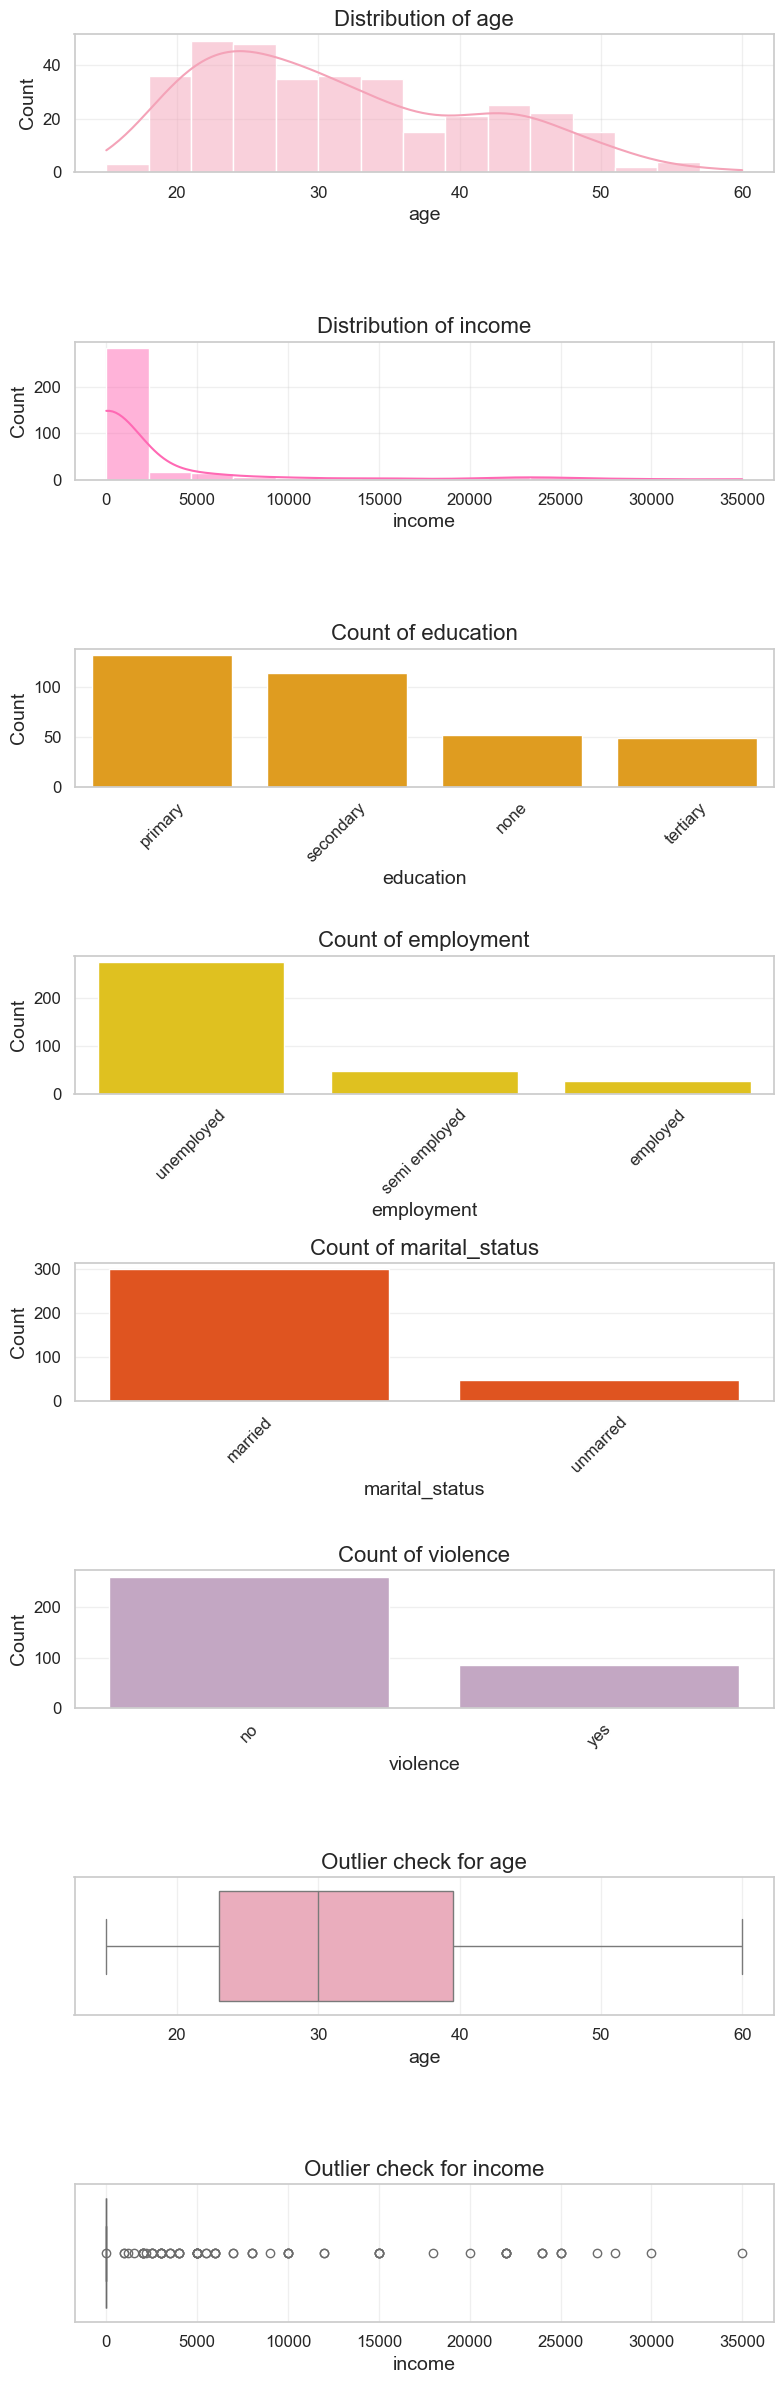

Outliers in age:
Series([], Name: age, dtype: int64)

Outliers in income:
328    20000
329    22000
330    22000
331    22000
332    22000
333    22000
334    24000
335    24000
336    24000
337    25000
338    25000
339    25000
340    27000
341    28000
342    30000
343    35000
Name: income, dtype: int64



In [277]:
# define num/cat
num_col_dv = ["age", "income"]
cat_col_dv = ["education", "employment", "marital_status", "violence"]

# figures
total_plots = len(num_col_dv) + len(cat_col_dv) + len(num_col_dv)
fig, axes = plt.subplots(total_plots, 1, figsize=(8, total_plots*3))
axes = axes.flatten()  

# color palette
palette = list(colors.values())

plot_idx = 0

# numeric histograms
for i, col in enumerate(num_col_dv):
    sns.histplot(dv_df[col].dropna(), kde=True, color=palette[i % len(palette)], ax=axes[plot_idx], bins=15)
    axes[plot_idx].set_title(f"Distribution of {col}")
    axes[plot_idx].set_xlabel(col)
    axes[plot_idx].set_ylabel("Count")
    plot_idx += 1

# categorical bar plots
for i, col in enumerate(cat_col_dv):
    sns.countplot(
        data=dv_df,
        x=col,
        order=dv_df[col].value_counts().index,
        color=palette[(i+len(num_col_dv)) % len(palette)],
        ax=axes[plot_idx]
    )
    axes[plot_idx].set_title(f"Count of {col}")
    axes[plot_idx].set_xlabel(col)
    axes[plot_idx].set_ylabel("Count")
    axes[plot_idx].tick_params(axis='x', rotation=45)
    plot_idx += 1

# boxplot outlier check
for i, col in enumerate(num_col_dv):
    sns.boxplot(x=dv_df[col], color=palette[(i+len(num_col_dv)+len(cat_col_dv)) % len(palette)], ax=axes[plot_idx])
    axes[plot_idx].set_title(f"Outlier check for {col}")
    plot_idx += 1

plt.tight_layout()
plt.show()

# print outliers
for col in num_col_dv:
    z_scores = zscore(dv_df[col].dropna())
    outliers = dv_df[col][np.abs(z_scores) > 3]
    print(f"Outliers in {col}:\n{outliers}\n")

#### 3.1.2 Bivariate Analysis

**Key Questions**
- Which employment status has highest violence rate?
- Does violence vary by marital status?
- Is there an age effect?
- Income correlation with violence?

**Steps**:

*violence vs each predictor*
- Chi-square tests for categorical variables
- T-tests or Mann-Whitney U for continuous variables
- Visualize with grouped bar charts and box plots


=== education vs violence ===
violence   no  yes
education         
none       41   11
primary    86   46
secondary  94   20
tertiary   40    9
Chi-square test: chi2=11.83, p=0.0080


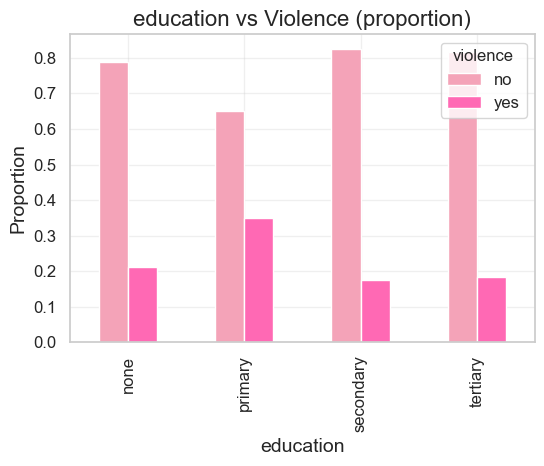


=== employment vs violence ===
violence        no  yes
employment             
employed        20    6
semi employed   42    5
unemployed     199   75
Chi-square test: chi2=6.07, p=0.0481


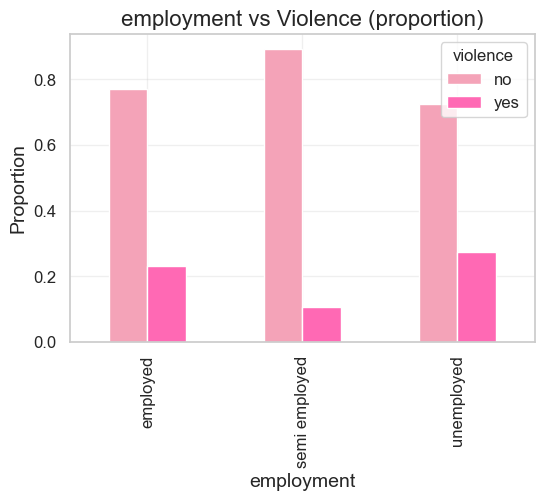


=== marital_status vs violence ===
violence         no  yes
marital_status          
married         217   83
unmarred         44    3
Chi-square test: chi2=8.77, p=0.0031


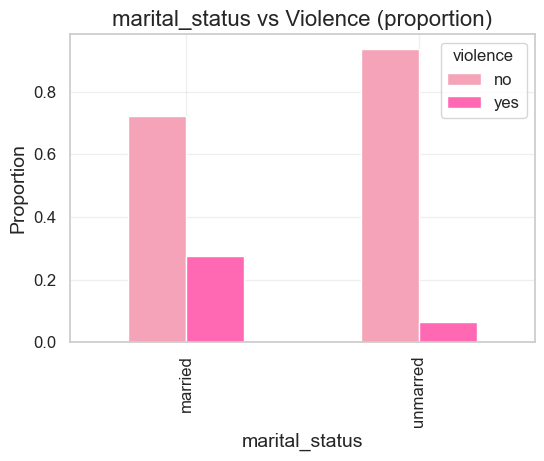


=== violence vs violence ===
violence   no  yes
violence          
no        261    0
yes         0   86
Chi-square test: chi2=341.66, p=0.0000


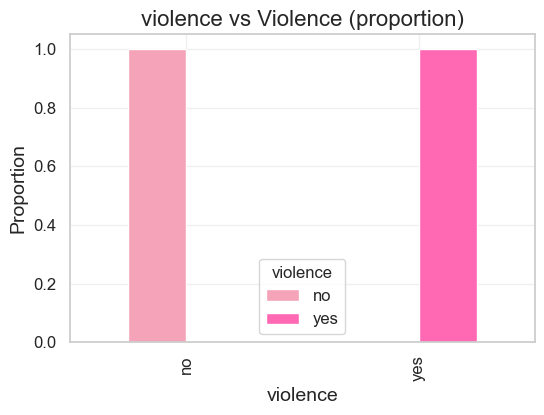

In [278]:
# categorical values vs violence

for col in cat_col_dv:
    print(f"\n=== {col} vs violence ===")
    
    # contingency table
    ct = pd.crosstab(dv_df[col], dv_df["violence"])
    print(ct)
    
    # Chi-square test
    chi2, p, dof, ex = stats.chi2_contingency(ct)
    print(f"Chi-square test: chi2={chi2:.2f}, p={p:.4f}")
    
    # grouped bar plot
    ct_prop = ct.div(ct.sum(axis=1), axis=0)
    ct_prop.plot(kind='bar', stacked=False, color=palette[:len(ct_prop)], figsize=(6,4))
    plt.title(f"{col} vs Violence (proportion)")
    plt.ylabel("Proportion")
    plt.show()


=== age vs violence ===
Mann-Whitney U: stat=13541.50, p=0.0040


C:\Users\black\AppData\Local\Temp\ipykernel_30944\2167476297.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="violence", y=col, data=dv_df, palette=palette[:2])


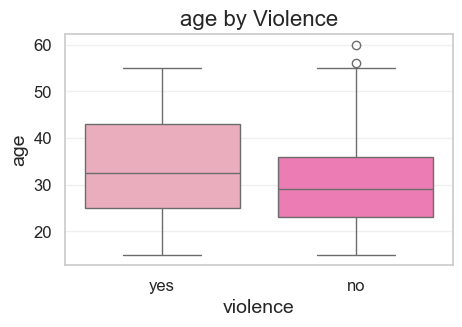

C:\Users\black\AppData\Local\Temp\ipykernel_30944\2167476297.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="violence", y=col, data=dv_df, palette=palette[:2])



=== income vs violence ===
Mann-Whitney U: stat=9853.00, p=0.0184


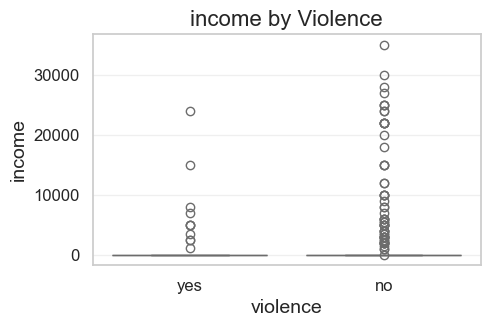

In [279]:
# numerical values vs violence

for col in num_col_dv:
    print(f"\n=== {col} vs violence ===")
    
    # Split by violence
    group_yes = dv_df.loc[dv_df["violence"]=="yes", col].astype(float)
    group_no = dv_df.loc[dv_df["violence"]=="no", col].astype(float)
    
    # Normality check
    stat_yes, p_yes = stats.shapiro(group_yes)
    stat_no, p_no = stats.shapiro(group_no)
    
    if p_yes>0.05 and p_no>0.05:
        # parametric test
        stat, p_val = stats.ttest_ind(group_yes, group_no, equal_var=False)
        test_type = "T-test"
    else:
        # non-parametric test
        stat, p_val = stats.mannwhitneyu(group_yes, group_no)
        test_type = "Mann-Whitney U"
        
    print(f"{test_type}: stat={stat:.2f}, p={p_val:.4f}")
    
    # Boxplot
    sns.boxplot(x="violence", y=col, data=dv_df, palette=palette[:2])
    plt.title(f"{col} by Violence")
    plt.show()


#### 3.1.3 Multivariate Analysis 

**Steps**:
- Correlation matrix for age and income
- Crosstabs for categorical combinations (e.g. employment × marital_status × violence)
- Segmentation analysis: creating profiles of high-risk vs. low-risk groups

In [280]:
# age income correlation
dv_df["income"] = dv_df["income"].astype(float)
dv_df["age"] = dv_df["age"].astype(float)
dv_df["violence_binary"] = dv_df["violence"].map({"yes":1, "no":0})

for col in ["age", "income"]:
    corr, p = stats.pearsonr(dv_df[col], dv_df["violence_binary"])
    print(f"Correlation of {col} with violence: r={corr:.2f}, p={p:.4f}")

Correlation of age with violence: r=0.17, p=0.0018
Correlation of income with violence: r=-0.12, p=0.0258


Crosstab: Employment × Marital Status × Violence
violence                       no  yes
employment    marital_status          
employed      married        0.75 0.25
              unmarred       1.00 0.00
semi employed married        0.86 0.14
              unmarred       1.00 0.00
unemployed    married        0.70 0.30
              unmarred       0.91 0.09
All                          0.75 0.25


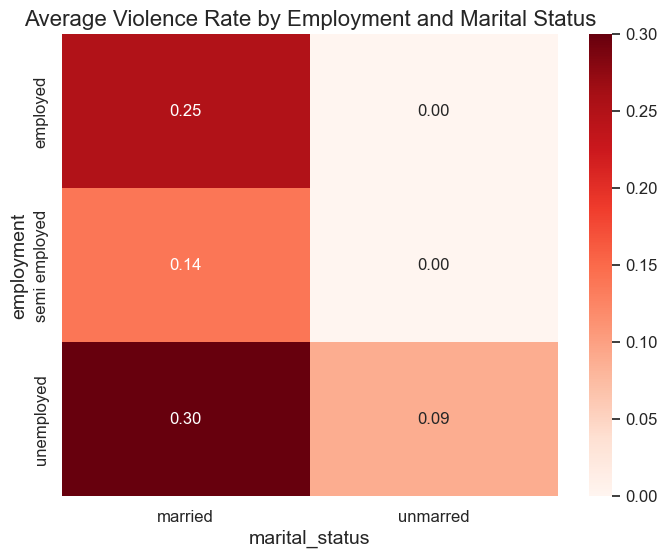

In [281]:
# multi-way crosstab
multi_ct = pd.crosstab(
    index=[dv_df['employment'], dv_df['marital_status']],
    columns=dv_df['violence'],
    margins=True,  
    normalize='index' 
)
print("Crosstab: Employment × Marital Status × Violence")
print(multi_ct)

# heatmap visualization
plt.figure(figsize=(8,6))
sns.heatmap(
    pd.crosstab(dv_df['employment'], dv_df['marital_status'], values=dv_df['violence'].map({'yes':1,'no':0}), aggfunc='mean'),
    annot=True, fmt=".2f",
    cmap="Reds"
)
plt.title("Average Violence Rate by Employment and Marital Status")
plt.show()

       employment marital_status  education  violence_rate  count risk_profile
0        employed        married    primary           0.60      5    high-risk
11     unemployed        married    primary           0.37    111    high-risk
13     unemployed        married   tertiary           0.35     17    high-risk
14     unemployed       unmarred    primary           0.33      3    high-risk
6   semi employed        married  secondary           0.27     11    high-risk
1        employed        married  secondary           0.25      4    high-risk
10     unemployed        married       none           0.23     43     low-risk
12     unemployed        married  secondary           0.22     69     low-risk
2        employed        married   tertiary           0.13     15     low-risk
4   semi employed        married       none           0.11      9     low-risk
16     unemployed       unmarred   tertiary           0.10     10     low-risk
5   semi employed        married    primary         

C:\Users\black\AppData\Local\Temp\ipykernel_30944\3727313968.py:21: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.barplot(


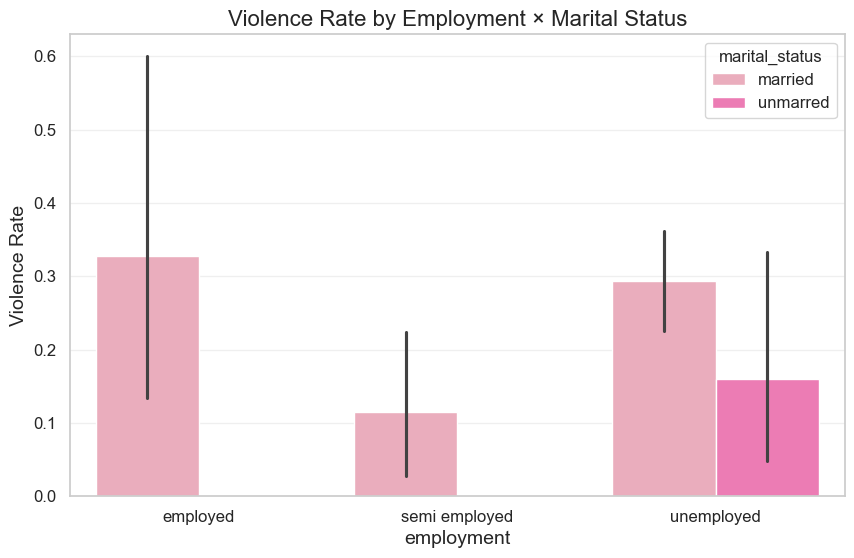

In [282]:
# creating a risk score using violence probability and categorical values

# convert categorical variables to binary dummies for simple scoring
risk_df = dv_df.copy()
risk_df['violence_binary'] = risk_df['violence'].map({'yes':1,'no':0})

# group by key categorical variables
grouped = risk_df.groupby(['employment','marital_status','education']).agg(
    violence_rate=('violence_binary','mean'),
    count=('violence_binary','size')
).reset_index()

# high-risk vs low-risk
threshold = risk_df['violence_binary'].mean()  
grouped['risk_profile'] = grouped['violence_rate'].apply(lambda x: 'high-risk' if x>threshold else 'low-risk')

print(grouped.sort_values('violence_rate', ascending=False))

# visualize
plt.figure(figsize=(10,6))
sns.barplot(
    x='employment',
    y='violence_rate',
    hue='marital_status',
    data=grouped,
    palette=palette[:3]
)
plt.title("Violence Rate by Employment × Marital Status")
plt.ylabel("Violence Rate")
plt.show()

#### 3.1.4 Aggregation

In [283]:
# aggregate violence by age
age_agg = dv_df.groupby('age')['violence_binary'].apply(lambda x: (x== 1).mean()).reset_index()

# aggregate violence by education
edu_agg = dv_df.groupby('education')['violence_binary'].apply(lambda x: (x== 1).mean()).reset_index()

# aggregate violence by employment
emp_agg = dv_df.groupby('employment')['violence_binary'].apply(lambda x: (x== 1).mean()).reset_index()

### 3.2 Violence Against Women & Girls Dataset

In [284]:
# merge domestic dataset with aggregated VAWG rates by demographic groups
vawg_long = vawg_df.melt(id_vars=['country', 'question'], var_name='demographic_group', value_name='violence_rate' )

# convert percentages to numeric if necessary 
vawg_long['violence_rate'] = pd.to_numeric(vawg_long['violence_rate'], errors='coerce')

# create separate mappings for age, education, and employment
age_mapping = {
    '15-24': 'age_15_24',
    '25-34': 'age_25_34',
    '35-49': 'age_35_49'
}

edu_mapping = {
    'higher': 'education_higher',
    'primary': 'education_primary',
    'none': 'education_no_education',
    'secondary': 'education_secondary'
}

emp_mapping = {
    'employed_for_cash': 'employment_employed_for_cash',
    'employed_for_kind': 'employment_employed_for_kind',
    'unemployed': 'employment_unemployed'
}

# function to assign average violence rate from VAWG based on individual demographics
def assign_vawg_rate(row, vawg_long):
    rates = []

    # check age
    age_col = age_mapping.get(row['age'])
    if age_col:
        age_rate = vawg_long[vawg_long['demographic_group'] == age_col]['violence_rate'].mean()
        if not np.isnan(age_rate):
            rates.append(age_rate)
    
    # check education
    edu_col = edu_mapping.get(row['education'])
    if edu_col:
        edu_rate = vawg_long[vawg_long['demographic_group'] == edu_col]['violence_rate'].mean()
        if not np.isnan(edu_rate):
            rates.append(edu_rate)
    
    # check employment
    emp_col = emp_mapping.get(row['employment'])
    if emp_col:
        emp_rate = vawg_long[vawg_long['demographic_group'] == emp_col]['violence_rate'].mean()
        if not np.isnan(emp_rate):
            rates.append(emp_rate)
    
    # take the average of available rates
    if rates:
        return np.mean(rates)
    else:
        return np.nan

dv_df['vawg_rate'] = dv_df.apply(assign_vawg_rate, axis=1, vawg_long=vawg_long)




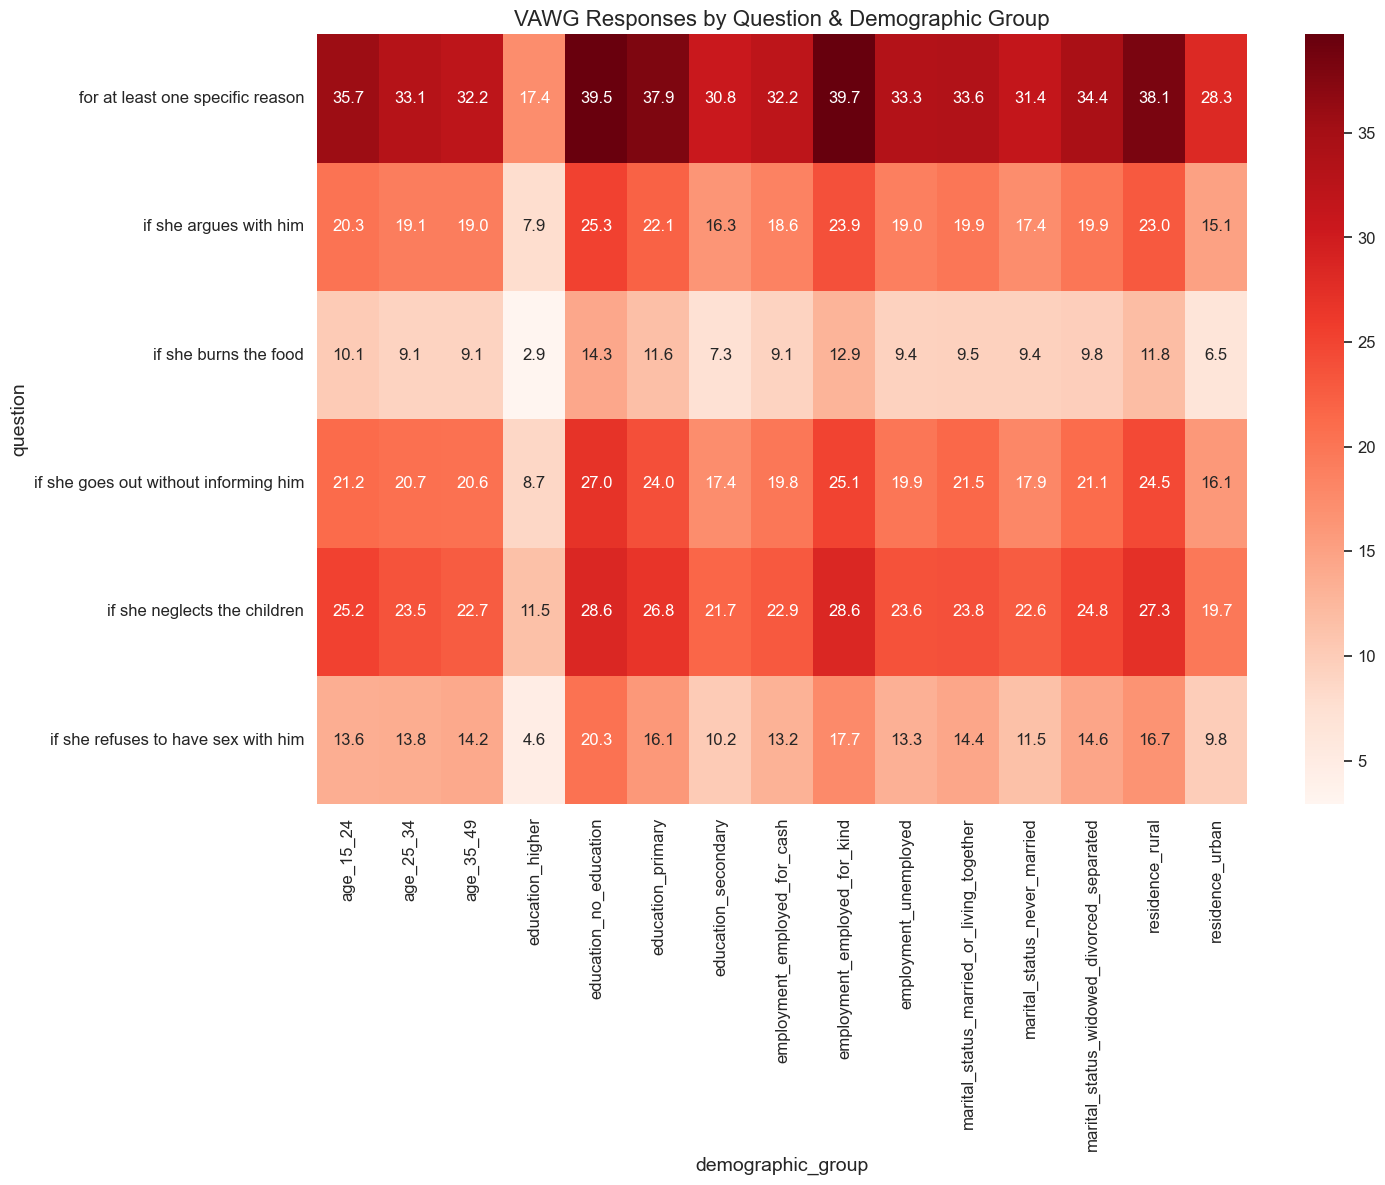

In [285]:
# Average violence rate by age group
vawg_age_avg = vawg_long.groupby('demographic_group')['violence_rate'].mean().reset_index()

# Heatmap per question
vawg_pivot = vawg_long.pivot_table(index='question', columns='demographic_group', values='violence_rate')
plt.figure(figsize=(15,10))
sns.heatmap(vawg_pivot, cmap='Reds', annot=True, fmt=".1f")
plt.title("VAWG Responses by Question & Demographic Group")
plt.show()


In [286]:
individual_df = dv_df.drop(columns=["violence"])
individual_df = individual_df.dropna(subset= "vawg_rate")

## 4. Country-Level Analysis

### 4.2 Freedom & Danger Indices

#### 4.2.1 Freedom Datset

- How do hf_score, pf_score, ef_score correlate with each other?
- Which freedom dimension matters most?


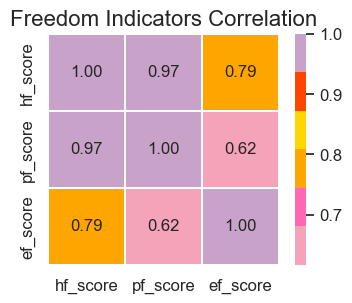

In [287]:
# freedom  correlation analysis
freedom_scores = hfi_df[["hf_score", "pf_score", "ef_score"]]

# corr matrix
corr_freedom = freedom_scores.corr()

# plt heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(
    corr_freedom,
    annot=True,
    cmap=list(colors.values()), 
    fmt=".2f",
    linewidths=0.3,
    square=True
)
plt.title("Freedom Indicators Correlation")
plt.show()


!hf score is most likely a combined calculation from the ef & pf score! -> redundant data

- hf = human freedom
- ef = economic freedom
- pf = personal freedom

In [288]:
# droping hf for master table 
hfi_df_master = hfi_df.drop(columns=["hf_score", "country"])

#### 4.2.2 Danger Dataset

- Create correlation heatmap of all 10 indices
- Identify which indices cluster together (PCA)
- Some indices might be redundant (e.g. WPSI vs WDI)

In [289]:
mdc_old = pd.read_csv(r"C:\Users\black\Documents\Ironhack\final_project\data\clean\arpitsinghaiml_most-dangerous-countries-for-women-2024\most-dangerous-countries-for-women-2024.csv")

mdc_old = mdc_old.rename(columns={
    "MostDangerousCountriesForWomen_WomenPeaceAndSecurityIndex_Score_2023" : "wpsi",
    "MostDangerousCountriesForWomen_WomensDangerIndexWDI_TotalScore_2019" : "wdi",
    'MostDangerousCountriesForWomen_WDIStreetSafety_2019' : "wss",
    'MostDangerousCountriesForWomen_WDIIntentionalHomicide_2019' : "ih",
    'MostDangerousCountriesForWomen_WDINonPartnerViolence_2019' : "npv",
    'MostDangerousCountriesForWomen_WDIIntimatePartnerViolence_2019' : "ipv",
    'MostDangerousCountriesForWomen_WDILegalDiscrimination_2019' : "ld",
    'MostDangerousCountriesForWomen_WDIGlobalGenderGap_2019' : "ggg",
    'MostDangerousCountriesForWomen_WDIGenderInequality_2019' : "gi",
    'MostDangerousCountriesForWomen_WDIAttitudesTowardViolence_2019' : "atv"
    })

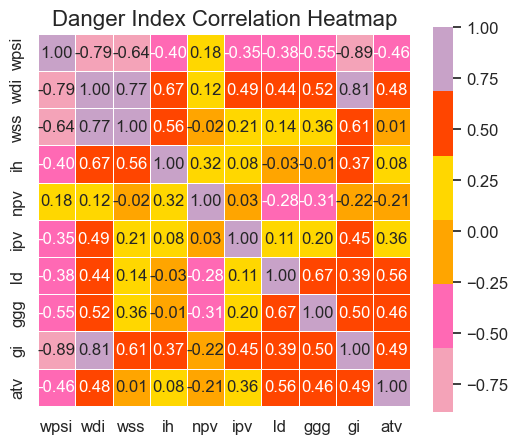

      wpsi   wdi   wss    ih   npv   ipv    ld   ggg    gi   atv
wpsi  1.00 -0.79 -0.64 -0.40  0.18 -0.35 -0.38 -0.55 -0.89 -0.46
wdi  -0.79  1.00  0.77  0.67  0.12  0.49  0.44  0.52  0.81  0.48
wss  -0.64  0.77  1.00  0.56 -0.02  0.21  0.14  0.36  0.61  0.01
ih   -0.40  0.67  0.56  1.00  0.32  0.08 -0.03 -0.01  0.37  0.08
npv   0.18  0.12 -0.02  0.32  1.00  0.03 -0.28 -0.31 -0.22 -0.21
ipv  -0.35  0.49  0.21  0.08  0.03  1.00  0.11  0.20  0.45  0.36
ld   -0.38  0.44  0.14 -0.03 -0.28  0.11  1.00  0.67  0.39  0.56
ggg  -0.55  0.52  0.36 -0.01 -0.31  0.20  0.67  1.00  0.50  0.46
gi   -0.89  0.81  0.61  0.37 -0.22  0.45  0.39  0.50  1.00  0.49
atv  -0.46  0.48  0.01  0.08 -0.21  0.36  0.56  0.46  0.49  1.00


In [290]:
# corr heatmap danger 
mdc_cols = ["wpsi", "wdi", "wss", "ih", "npv", "ipv", "ld", "ggg", "gi", "atv"]
mdc_scores = mdc_old[mdc_cols]

corr_mdc = mdc_scores.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_mdc,
    annot=True,
    cmap=list(colors.values()), 
    fmt=".2f",
    linewidths=0.4,
    square=True
)
plt.title("Danger Index Correlation Heatmap")
plt.show()

print(corr_mdc)

1. pattern: general danger-inequality dimension
- wpsi <-> gi: -0.89 -> very high inverser corr
- etc
    --> the higher gender inequality, women danger index, women safety & security, ggg, ld, etc., the lower the women peace & security index

2. violence-specific dimension:
- ipv, npv, atv


Explained variance by component:
PC1: 46.37%
PC2: 19.53%
PC3: 10.28%


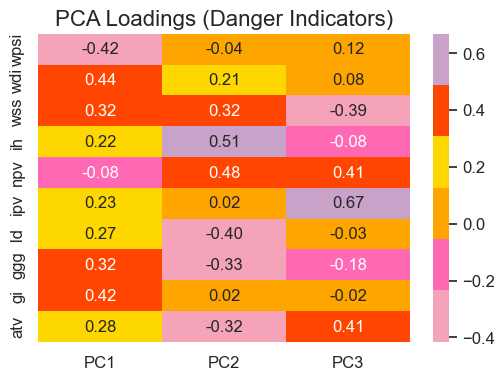


PCA Loadings Table:
       PC1   PC2   PC3
wpsi -0.42 -0.04  0.12
wdi   0.44  0.21  0.08
wss   0.32  0.32 -0.39
ih    0.22  0.51 -0.08
npv  -0.08  0.48  0.41
ipv   0.23  0.02  0.67
ld    0.27 -0.40 -0.03
ggg   0.32 -0.33 -0.18
gi    0.42  0.02 -0.02
atv   0.28 -0.32  0.41


In [291]:
# PCA

# drop NaN & standardize
mdc_clean = mdc_scores.dropna()

scaler = StandardScaler()
mdc_scaled = scaler.fit_transform(mdc_clean)

# pca
pca = PCA(n_components=3, random_state=RANDOM_STATE)
pca_fit = pca.fit(mdc_scaled)

print("\nExplained variance by component:")
for i, v in enumerate(pca_fit.explained_variance_ratio_, 1):
    print(f"PC{i}: {v:.2%}")

# visualize
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i}" for i in range(1, 4)],
    index=mdc_cols
)

plt.figure(figsize=(6, 4))
sns.heatmap(
    loadings,
    annot=True,
    cmap=list(colors.values()),
    fmt=".2f"
)
plt.title("PCA Loadings (Danger Indicators)")
plt.show()

print("\nPCA Loadings Table:")
print(loadings)

**PC1 Global Danger & Gender Inequality**
- wdi, gi, ggg, wss, ld --> high positive leads to wpsi --> high negative
- represents general danger

**PC2 Interpersonal Violence vs Structural Discrimination**
- ih, npv --> interpersonal violence
- ld, ggg --> institutional discrimination
- dofferent forms of harm

**PC3 Intimate & Non Partner Violence**
- ipv & npv --> interpersonal relationships isolated from broader danger

In [292]:
mdc_df.head()

,country,wdi,wss,ih,npv,ipv,ld,atv,iso
0,India,541.25,41.00,30.00,19.00,83.00,44.00,74.00,IND
1,China,444.55,23.00,6.00,70.00,86.00,44.00,80.00,CHN
2,United States,456.31,51.00,25.00,75.00,81.00,24.00,21.00,USA
3,Indonesia,442.10,37.00,3.00,30.00,66.00,54.00,51.00,IDN
4,Brazil,624.28,96.00,49.00,44.00,82.00,30.00,25.00,BRA


In [293]:
# droping wss (high correlation with wdi) and country for master table

mdc_df_master = mdc_df.drop(columns=["wss", "country"])

In [294]:
# droping country
wpsi_df_master = wpsi_df.drop(columns=["country"])

### 4.3 Economic Indicators

#### 4.3.1 GDP

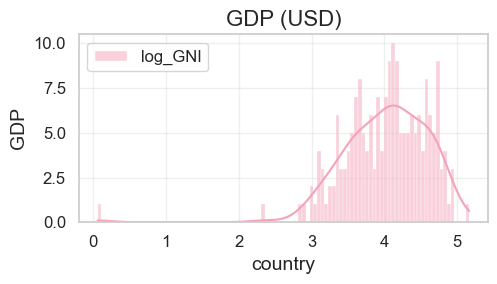

In [295]:
# histogram log-transformed GDP

palette = list(colors.values())

sns.histplot(gdp_df, kde=True, color=palette[i % len(palette)], bins=100)
plt.title(f"GDP (USD)")
plt.xlabel("country")
plt.ylabel("GDP")

plt.tight_layout()
plt.show()


In [296]:
gdp_df.isna().sum()

country    0
log_GNI    0
iso        0
dtype: int64

In [297]:
# categorize into income groups: low, middle, high

def categorize_income(log_GNI):
        if pd.isna(log_GNI):
            return None
        elif log_GNI < 0.05499586152914153: 
            return 'Low Income'
        elif log_GNI < 0.6498214632245652:
            return 'Lower-Middle Income'
        elif log_GNI < 1.1412929600815933:
            return 'Upper-Middle Income'
        else:
            return 'High Income'
    
gdp_df['income_category'] = gdp_df['log_GNI'].apply(categorize_income)

#### 4.3.2 Gender Wage Gap

In [298]:
def analyze_wage_gap(gwg_df, gdp_df=None, hfi_df=None):
    """
    Analyze gender wage gap with GDP income categories and regional info.
    """
    # copy to avoid modifying the original
    wg_analysis = gwg_df.copy()

    # merge country information
    if hfi_df is not None and 'iso' in hfi_df.columns:
        wg_analysis = wg_analysis.merge(
            hfi_df[['iso']],
            on='iso',
            how='left'
        )

    # merge GDP-based income categories
    if gdp_df is not None and 'income_category' in gdp_df.columns:
        wg_analysis = wg_analysis.merge(
            gdp_df[['iso', 'income_category']],
            on='iso',
            how='left'
        )

    # Summary statistics
    stats_summary = {
        'total_countries': len(wg_analysis),
        'coverage_limitation': f"Only {len(wg_analysis)} wage gap observations available",
        'mean_gap': wg_analysis['gwg_%'].mean(),
        'median_gap': wg_analysis['gwg_%'].median(),
        'std_gap': wg_analysis['gwg_%'].std(),
        'min_gap': wg_analysis['gwg_%'].min(),
        'max_gap': wg_analysis['gwg_%'].max()
    }

    print(f"\nDATA LIMITATION: {stats_summary['coverage_limitation']}")
    print(f"\nWage Gap Stats (%):")
    print(f"  Mean:   {stats_summary['mean_gap']:.2f}")
    print(f"  Median: {stats_summary['median_gap']:.2f}")
    print(f"  Std Dev:{stats_summary['std_gap']:.2f}")
    print(f"  Range:  {stats_summary['min_gap']:.2f} – {stats_summary['max_gap']:.2f}")

    # Regional description
    if 'iso' in wg_analysis.columns:
        print("\nWage Gap by COuntry:")
        iso_stats = wg_analysis.groupby('iso')['gwg_%'].agg(['mean', 'count'])
        for iso, row in iso_stats.iterrows():
            print(f"  {iso}: {row['mean']:.2f}% (n={int(row['count'])})")

    # visualization
    n_plots = 3 if 'iso' in wg_analysis.columns else 2
    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 5))

    if n_plots == 2:
        axes = [axes[0], axes[1], None]

    # 1 — Wage Gap Distribution
    axes[0].hist(
        wg_analysis['gwg_%'].dropna(),
        bins=15,
        color=list(colors.values())[0],
        edgecolor='black',
        alpha=0.8
    )
    axes[0].set_title("Wage Gap Distribution")
    axes[0].set_xlabel("Wage Gap (%)")
    axes[0].set_ylabel("Frequency")
    axes[0].axvline(wg_analysis['gwg_%'].mean(), color='red', linestyle='--')
    axes[0].grid(alpha=0.3)

    # top 10 & Bottom 10
    top10 = wg_analysis.nlargest(10, 'gwg_%')[['iso', 'gwg_%']]
    bottom10 = wg_analysis.nsmallest(10, 'gwg_%')[['iso', 'gwg_%']]
    combined = pd.concat([top10, bottom10])

    color_list = [
        list(colors.values())[4] if iso in top10['iso'].values else list(colors.values())[3]
        for iso in combined['iso']
    ]

    axes[1].barh(combined['iso'], combined['gwg_%'], color=color_list, edgecolor='black')
    axes[1].set_title("Top & Bottom 10 Wage Gaps")
    axes[1].set_xlabel("Wage Gap (%)")
    axes[1].grid(axis='x', alpha=0.3)

    # regional Boxplot
    if axes[2] is not None and 'iso' in wg_analysis.columns:
        sns.boxplot(
            data=wg_analysis.dropna(subset=['iso']),
            x='gwg_%', y='iso',
            palette=list(colors.values()),
            ax=axes[2]
        )
        axes[2].set_title("Wage Gap by Country")
        axes[2].set_xlabel("Wage Gap (%)")

    plt.tight_layout()
    plt.show()

    return wg_analysis, stats_summary




DATA LIMITATION: Only 43 wage gap observations available

Wage Gap Stats (%):
  Mean:   36.89
  Median: 20.29
  Std Dev:30.47
  Range:  1.11 – 127.37

Wage Gap by COuntry:
  AUS: 16.14% (n=1)
  AUT: 14.88% (n=1)
  BEL: 34.09% (n=1)
  BGR: 30.30% (n=1)
  CAN: 18.52% (n=1)
  CHE: 15.10% (n=1)
  COL: 57.88% (n=1)
  CRI: 47.25% (n=1)
  CYP: 15.87% (n=1)
  CZE: 15.13% (n=1)
  DEU: 15.25% (n=1)
  DNK: 48.63% (n=1)
  ESP: 86.22% (n=1)
  EST: 17.32% (n=1)
  EU27: 111.39% (n=1)
  FIN: 18.86% (n=1)
  FRA: 11.82% (n=1)
  GBR: 16.31% (n=1)
  GRC: 59.09% (n=1)
  HRV: 79.15% (n=1)
  HUN: 50.63% (n=1)
  IRL: 82.84% (n=1)
  ISL: 12.90% (n=1)
  ISR: 22.66% (n=1)
  ITA: 57.08% (n=1)
  JPN: 23.54% (n=1)
  KOR: 34.11% (n=1)
  LTU: 11.69% (n=1)
  LVA: 20.29% (n=1)
  MEX: 14.00% (n=1)
  MLT: 1.11% (n=1)
  NLD: 12.66% (n=1)
  NOR: 51.29% (n=1)
  NZL: 78.70% (n=1)
  OECD: 127.37% (n=1)
  POL: 11.50% (n=1)
  PRT: 11.66% (n=1)
  ROU: 34.97% (n=1)
  SVK: 15.66% (n=1)
  SVN: 81.94% (n=1)
  SWE: 71.43% (n=1)
  TU

C:\Users\black\AppData\Local\Temp\ipykernel_30944\4253910444.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\black\AppData\Local\Temp\ipykernel_30944\4253910444.py:87: UserWarning: 
The palette list has fewer values (6) than needed (43) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(


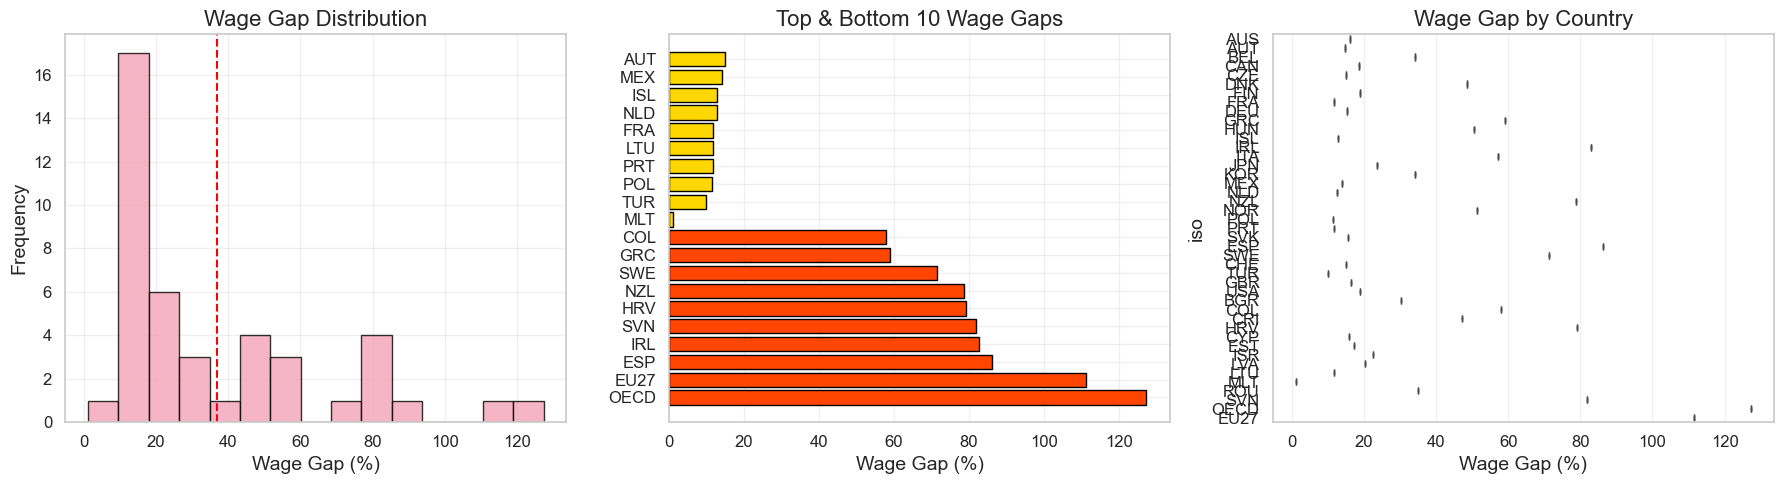

(     iso  gwg_%
 0    AUS  16.14
 1    AUT  14.88
 2    BEL  34.09
 3    CAN  18.52
 4    CZE  15.13
 5    DNK  48.63
 6    FIN  18.86
 7    FRA  11.82
 8    DEU  15.25
 9    GRC  59.09
 10   HUN  50.63
 11   ISL  12.90
 12   IRL  82.84
 13   ITA  57.08
 14   JPN  23.54
 15   KOR  34.11
 16   MEX  14.00
 17   NLD  12.66
 18   NZL  78.70
 19   NOR  51.29
 20   POL  11.50
 21   PRT  11.66
 22   SVK  15.66
 23   ESP  86.22
 24   SWE  71.43
 25   CHE  15.10
 26   TUR   9.98
 27   GBR  16.31
 28   USA  18.91
 29   BGR  30.30
 30   COL  57.88
 31   CRI  47.25
 32   HRV  79.15
 33   CYP  15.87
 34   EST  17.32
 35   ISR  22.66
 36   LVA  20.29
 37   LTU  11.69
 38   MLT   1.11
 39   ROU  34.97
 40   SVN  81.94
 41  OECD 127.37
 42  EU27 111.39,
 {'total_countries': 43,
  'coverage_limitation': 'Only 43 wage gap observations available',
  'mean_gap': np.float64(36.885860465116274),
  'median_gap': np.float64(20.289),
  'std_gap': np.float64(30.4692917718037),
  'min_gap': np.float64(1.109),
 

In [299]:
analyze_wage_gap(gwg_df, gdp_df=None, hfi_df=None)

This dataset won't be part of further analysis. There is too little data available and the gender wage gap is represented by a lot of other features (economic freedom, gii, etc.)

#### 4.3.3 Unemployment

In [300]:
# comput gender unemployment gap
# pivot -> female & male unemployment rates
unemp_pivot = gud_df.pivot_table(
    index=['country', 'iso', 'age'],
    columns='sex',
    values='percentage_unemployement'
).reset_index()

# rename columns for clarity
unemp_pivot = unemp_pivot.rename(columns={
    'Female': 'female_unemployment_rate',
    'Male': 'male_unemployment_rate'
})

# calculate gender unemployment gap
unemp_pivot['unemployment_gender_gap'] = (
    unemp_pivot['female_unemployment_rate'] - unemp_pivot['male_unemployment_rate']
)


In [301]:
# age specific unemployment gaps
unemp_pivot['gap_under15'] = unemp_pivot.apply(
    lambda row: row['unemployment_gender_gap'] if row['age'] == 'Under 15' else None, axis=1
)

unemp_pivot['gap_15_24'] = unemp_pivot.apply(
    lambda row: row['unemployment_gender_gap'] if row['age'] == '15-24' else None, axis=1
)

unemp_pivot['gap_25_plus'] = unemp_pivot.apply(
    lambda row: row['unemployment_gender_gap'] if row['age'] == '25+' else None, axis=1
)

In [302]:
# country-level summary table
unemp_summary = unemp_pivot.groupby(['country', 'iso']).agg({
    'female_unemployment_rate': 'mean',
    'male_unemployment_rate': 'mean',
    'unemployment_gender_gap': 'mean'
}).reset_index()

In [303]:
unemp_pivot

sex,country,iso,age,female_unemployment_rate,male_unemployment_rate,unemployment_gender_gap,gap_under15,gap_15_24,gap_25_plus
0,Afghanistan,AFG,15-24,33.33,19.77,13.56,NaN,13.56,NaN
1,Afghanistan,AFG,25+,28.30,13.09,15.21,NaN,NaN,15.21
2,Afghanistan,AFG,Under 15,30.96,15.30,15.66,15.66,NaN,NaN
3,Albania,ALB,15-24,25.21,27.27,-2.06,NaN,-2.06,NaN
4,Albania,ALB,25+,9.49,9.32,0.16,NaN,NaN,0.16
...,...,...,...,...,...,...,...,...,...
562,Zambia,ZMB,25+,3.90,2.62,1.28,NaN,NaN,1.28
563,Zambia,ZMB,Under 15,4.85,3.60,1.25,1.25,NaN,NaN
564,Zimbabwe,ZWE,15-24,15.55,13.48,2.07,NaN,2.07,NaN
565,Zimbabwe,ZWE,25+,7.53,6.70,0.82,NaN,NaN,0.82


In [304]:
unemp_wide = unemp_pivot.pivot_table(
    index="iso",
    columns="age",
    values=["female_unemployment_rate", "male_unemployment_rate", "unemployment_gender_gap",
            "gap_under15", "gap_15_24", "gap_25_plus"],
    aggfunc="first"
)

unemp_wide.columns = ['_'.join(col).strip() for col in unemp_wide.columns.values]

In [305]:
unemp_wide.head()

,female_unemployment_rate_15-24,female_unemployment_rate_25+,female_unemployment_rate_Under 15,gap_15_24_15-24,gap_25_plus_25+,gap_under15_Under 15,male_unemployment_rate_15-24,male_unemployment_rate_25+,male_unemployment_rate_Under 15,unemployment_gender_gap_15-24,unemployment_gender_gap_25+,unemployment_gender_gap_Under 15
iso,,,,,,,,,,,,
AFG,33.33,28.30,30.96,13.56,15.21,15.66,19.77,13.09,15.30,13.56,15.21,15.66
AGO,25.46,10.45,14.16,-3.89,1.59,0.21,29.35,8.87,13.95,-3.89,1.59,0.21
ALB,25.21,9.49,10.68,-2.06,0.16,-0.27,27.27,9.32,10.95,-2.06,0.16,-0.27
ARE,18.43,5.56,6.64,11.79,3.76,4.58,6.64,1.80,2.07,11.79,3.76,4.58
ARG,19.93,5.73,7.39,2.20,1.07,1.14,17.73,4.66,6.26,2.20,1.07,1.14


In [306]:
# droping female_unemployement_rate & male_unemployement rate as represented by unemployement_gender_gap for master table
gud_df_master = unemp_wide[[
    'unemployment_gender_gap_15-24',
    'unemployment_gender_gap_25+',
    'unemployment_gender_gap_Under 15']]

gud_df_master = gud_df_master.rename(columns={ 
    'unemployment_gender_gap_15-24' : "gug_15-24",
    'unemployment_gender_gap_25+' : "gug_25+",
    'unemployment_gender_gap_Under 15' : "gug_under15",
})

### 4.4 Gender Inequality & Legal Frameworks

#### 4.4.1 Gender Inequality Index (GII)

- which components drive the GII most?
- calculation of gender gaps:

  - secondary education gap
  - labour force gap

In [307]:
# gender gap variables
gii_df["sec_edu_gap"] = (gii_df["m_secondary_educ"] - gii_df["f_secondary_educ"])

gii_df["lab_force_gap"] = (gii_df["m_labour_force"] - gii_df["f_labour_force"])

In [308]:
gii_df

,country,human_development,gii,rank,maternal_mortality,adolescent_birth_rate,seats_parliament,f_secondary_educ,m_secondary_educ,f_labour_force,m_labour_force,iso,human_development_encoded,sec_edu_gap,lab_force_gap
0,Switzerland,Very high,0.02,3.00,5.00,2.20,39.80,96.90,97.50,61.70,72.70,CHE,4.00,0.60,11.00
1,Norway,Very high,0.02,2.00,2.00,2.30,45.00,99.10,99.30,60.30,72.00,NOR,4.00,0.20,11.70
2,Iceland,Very high,0.04,8.00,4.00,5.40,47.60,99.80,99.70,61.70,70.50,ISL,4.00,-0.10,8.80
3,Hong Kong,Very high,NaN,NaN,NaN,1.60,NaN,77.10,83.40,53.50,65.80,HKG,4.00,6.30,12.30
4,Australia,Very high,0.07,19.00,6.00,8.10,37.90,94.60,94.40,61.10,70.50,AUS,4.00,-0.20,9.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,South Sudan,Low,0.59,150.00,1150.00,99.20,32.30,26.50,36.40,70.40,73.60,SSD,1.00,9.90,3.20
191,North Korea,NaN,NaN,NaN,89.00,2.30,17.60,NaN,NaN,77.20,86.10,PRK,NaN,NaN,8.90
192,Monaco,NaN,NaN,NaN,NaN,7.20,33.30,NaN,NaN,NaN,NaN,MCO,NaN,NaN,NaN
193,Nauru,NaN,NaN,NaN,NaN,72.50,10.50,NaN,NaN,NaN,NaN,NRU,NaN,NaN,NaN


In [309]:
# correlation 
num_col_gii = [
    'maternal_mortality',
    'adolescent_birth_rate',
    'seats_parliament',
    'f_secondary_educ',
    'm_secondary_educ',
    'f_labour_force',
    'm_labour_force',
    'sec_edu_gap',
    'lab_force_gap'
]

corr_with_gii = gii_df[num_col_gii + ['gii']].corr()['gii'].sort_values(ascending=False)

print("\nCorrelation of indicators with GII:\n")
print(corr_with_gii)


Correlation of indicators with GII:

gii                      1.00
adolescent_birth_rate    0.81
maternal_mortality       0.71
sec_edu_gap              0.45
lab_force_gap            0.17
m_labour_force           0.16
f_labour_force          -0.07
seats_parliament        -0.42
m_secondary_educ        -0.78
f_secondary_educ        -0.81
Name: gii, dtype: float64


C:\Users\black\AppData\Local\Temp\ipykernel_30944\1057961477.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\black\AppData\Local\Temp\ipykernel_30944\1057961477.py:2: UserWarning: The palette list has more values (12) than needed (10), which may not be intended.
  sns.barplot(


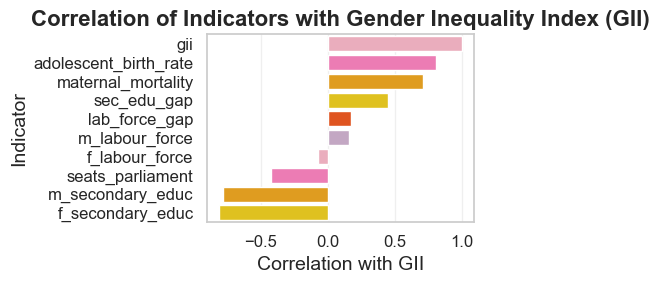

In [310]:
# visualize correlation
sns.barplot(
    x=corr_with_gii.values,
    y=corr_with_gii.index,
    palette=list(colors.values()) * 2
)

plt.title("Correlation of Indicators with Gender Inequality Index (GII)", fontsize=16, fontweight="bold")
plt.xlabel("Correlation with GII")
plt.ylabel("Indicator")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

C:\Users\black\AppData\Local\Temp\ipykernel_30944\2844353436.py:2: UserWarning: 
The palette list has fewer values (6) than needed (152) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


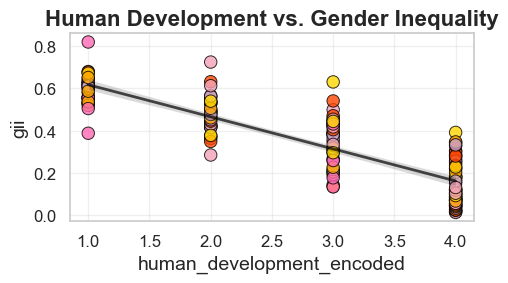

In [311]:
# human development vs GII
sns.scatterplot(
    data=gii_df,
    x="human_development_encoded",
    y="gii",
    hue="gii",
    palette=list(colors.values()),
    alpha=0.8,
    s=80,
    edgecolor="black"
)

plt.title("Human Development vs. Gender Inequality", fontsize=16, fontweight="bold")
plt.xlabel("Human Development Index (HDI)", fontsize=14)
plt.ylabel("Gender Inequality Index (GII)", fontsize=14)
plt.grid(alpha=0.3)

# remove legend
plt.legend().remove()

# trend line
sns.regplot(
    data=gii_df,
    x="human_development_encoded",
    y="gii",
    scatter=False,
    color="black",
    line_kws={"linewidth": 2, "alpha": 0.7}
)

plt.tight_layout()
plt.show()

In [312]:
gii_df.head()

,country,human_development,gii,rank,maternal_mortality,adolescent_birth_rate,seats_parliament,f_secondary_educ,m_secondary_educ,f_labour_force,m_labour_force,iso,human_development_encoded,sec_edu_gap,lab_force_gap
0,Switzerland,Very high,0.02,3.00,5.00,2.20,39.80,96.90,97.50,61.70,72.70,CHE,4.00,0.60,11.00
1,Norway,Very high,0.02,2.00,2.00,2.30,45.00,99.10,99.30,60.30,72.00,NOR,4.00,0.20,11.70
2,Iceland,Very high,0.04,8.00,4.00,5.40,47.60,99.80,99.70,61.70,70.50,ISL,4.00,-0.10,8.80
3,Hong Kong,Very high,NaN,NaN,NaN,1.60,NaN,77.10,83.40,53.50,65.80,HKG,4.00,6.30,12.30
4,Australia,Very high,0.07,19.00,6.00,8.10,37.90,94.60,94.40,61.10,70.50,AUS,4.00,-0.20,9.40


In [313]:
# droping human_dev (already encoded), 
# droping rank (not needed), 
# dropping f_secondary_educ & m_secondary_educ as represented by sec_edu_gap	
# f_labour_force & m_labour_force as represented by lab_force_gap

gii_df_master = gii_df[["gii", "maternal_mortality", "adolescent_birth_rate", "seats_parliament", "iso", "human_development_encoded", "sec_edu_gap", "lab_force_gap"]]

#### 4.4.2 Legal Framework (equal in marriage)

In [314]:
# merge with mdc_df["ld"] -> "legal discrimination"
legal_df = (lf_df.merge(mdc_df[['iso', 'ld']], on='iso', how='left').dropna(subset=['ld']).reset_index(drop=True))
legal_df.describe()


,percent_leg_equ_achiev_marriage,ld
count,41.00,41.00
mean,83.15,31.39
std,11.78,14.84
min,54.55,15.00
25%,81.82,22.00
50%,81.82,30.00
75%,90.91,39.00
max,100.00,87.00


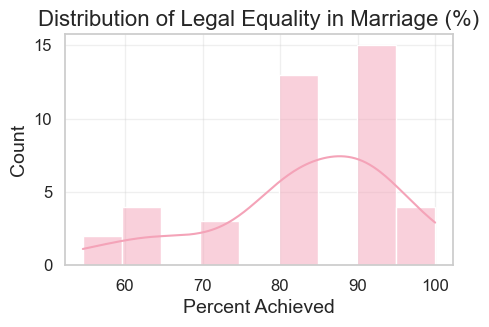

In [315]:
sns.histplot(legal_df["percent_leg_equ_achiev_marriage"], kde=True)
plt.title("Distribution of Legal Equality in Marriage (%)")
plt.xlabel("Percent Achieved")
plt.show()

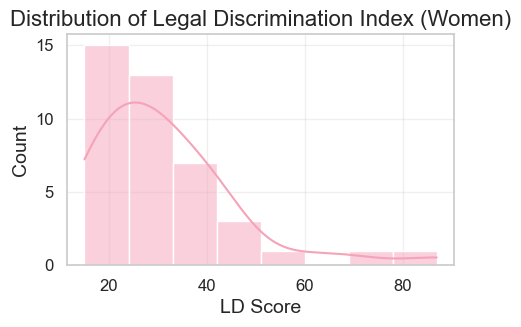

In [316]:
sns.histplot(legal_df["ld"], kde=True)
plt.title("Distribution of Legal Discrimination Index (Women)")
plt.xlabel("LD Score")
plt.show()

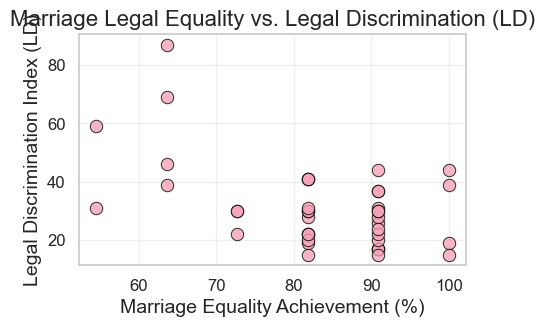

In [317]:
sns.scatterplot(
    data=legal_df,
    x="percent_leg_equ_achiev_marriage",
    y="ld",
    s=80,
    alpha=0.8,
    edgecolor="black"
)

plt.title("Marriage Legal Equality vs. Legal Discrimination (LD)")
plt.xlabel("Marriage Equality Achievement (%)")
plt.ylabel("Legal Discrimination Index (LD)")
plt.grid(alpha=0.3)
plt.show()

In [318]:
legal_df[["percent_leg_equ_achiev_marriage", "ld"]].corr()

,percent_leg_equ_achiev_marriage,ld
percent_leg_equ_achiev_marriage,1.00,-0.51
ld,-0.51,1.00


In [319]:
legal_df.sort_values("ld", ascending=False).head(10)

,country,percent_leg_equ_achiev_marriage,iso,ld
37,United Arab Emirates,63.64,ARE,87.00
21,Malaysia,63.64,MYS,69.00
34,Tunisia,54.55,TUN,59.00
23,Morocco,63.64,MAR,46.00
17,India,100.00,IND,44.00
8,China,90.91,CHN,44.00
36,Ukraine,81.82,UKR,41.00
33,Thailand,81.82,THA,41.00
35,Turkey,81.82,TUR,41.00
14,Germany,100.00,DEU,39.00


In [320]:
legal_df.sort_values("percent_leg_equ_achiev_marriage").head(10)

,country,percent_leg_equ_achiev_marriage,iso,ld
26,Philippines,54.55,PHL,31.00
34,Tunisia,54.55,TUN,59.00
23,Morocco,63.64,MAR,46.00
7,Chile,63.64,CHL,39.00
37,United Arab Emirates,63.64,ARE,87.00
21,Malaysia,63.64,MYS,69.00
15,Greece,72.73,GRC,22.00
3,Brazil,72.73,BRA,30.00
10,Czechia,72.73,CZE,30.00
24,Netherlands,81.82,NLD,20.00


In [321]:
# no country for master table
lf_df_master = lf_df.drop(columns="country")

#### 4.4.3 Equality Laws (continent-level)

#### 4.4.4 Partner Violence

In [322]:
# drop country for master table
aip_df_master = aip_df.drop(columns=["country"])
aip_df_master = aip_df_master.rename(columns={"value" : "ip_violence"})

## 5 Country-Master Table

In [323]:
# create country master table

# gdp index correctly
gdp_df = gdp_df.set_index("iso")

# list of datasets to merge
dfs_to_merge = [
    hfi_df_master,
    mdc_df_master,
    gud_df_master,
    gii_df_master,
    lf_df_master,
    aip_df_master,
    wpsi_df_master
]

# ensure right indexing on iso
index_dfs = []
for df in dfs_to_merge:
    df = df.copy()
    
    # If iso exists as a column, set as index
    if "iso" in df.columns:
        df = df.set_index("iso")
    
    # Optional: drop duplicate index entries
    df = df[~df.index.duplicated(keep="first")]
    
    index_dfs.append(df.sort_index())

# master join
country_master_df = gdp_df.copy()

for df in index_dfs:
    country_master_df = country_master_df.join(df, how="outer")


# inspect missingness + shape
print(country_master_df.shape)
print(country_master_df.isna().mean().sort_values(ascending=False).head(20))



(204, 25)
ih                                0.75
wdi                               0.75
npv                               0.75
ld                                0.75
ipv                               0.75
atv                               0.75
percent_leg_equ_achiev_marriage   0.41
ip_violence                       0.26
region                            0.19
pf_score                          0.19
ef_score                          0.19
gii                               0.17
wpsi                              0.14
sec_edu_gap                       0.14
lab_force_gap                     0.12
maternal_mortality                0.10
gug_15-24                         0.08
gug_25+                           0.08
gug_under15                       0.08
human_development_encoded         0.07
dtype: float64


Based on the high missing values of very important features, two datasets are going to be created:

- global/structural (wide) model datset: for predicting violence risk for all countries using structural features *Which structural factors predict VAW globally?*
- violence (deep, for validation & enrichment) model dataset: for validating the structural model predictions *Which factors are associated with actual measured VAW?*

### 5.0 Split in Global & Violence Country-Based Datasets

In [324]:
global_df = country_master_df.drop(columns=["npv", "ipv", "atv", "ld", "ih", "wdi", "region"])
violence_df = country_master_df[["npv", "ipv", "atv", "ld", "ih", "wdi", "gii", "sec_edu_gap", "lab_force_gap", "wpsi", "country"]]
violence_df = violence_df.dropna(subset=["npv", "ipv", "atv", "ld", "ih", "wdi", "gii", "sec_edu_gap", "lab_force_gap", "wpsi"])


In [325]:
global_df.head()

,country,log_GNI,income_category,pf_score,ef_score,gug_15-24,gug_25+,gug_under15,gii,maternal_mortality,adolescent_birth_rate,seats_parliament,human_development_encoded,sec_edu_gap,lab_force_gap,percent_leg_equ_achiev_marriage,ip_violence,wpsi
iso,,,,,,,,,,,,,,,,,,
AFG,Afghanistan,3.26,High Income,NaN,NaN,13.56,15.21,15.66,0.68,638.00,82.60,27.20,1.00,8.50,51.70,NaN,46.00,0.29
AGO,Angola,3.74,High Income,6.02,5.91,-3.89,1.59,0.21,0.54,241.00,138.40,29.50,2.00,23.30,5.10,NaN,38.00,0.60
ALB,Albania,4.15,High Income,7.69,7.64,-2.06,0.16,-0.27,0.14,15.00,14.50,35.70,3.00,-2.40,15.50,NaN,13.00,0.80
AND,Andorra,4.71,High Income,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.90,46.40,4.00,1.70,NaN,NaN,NaN,NaN
ARE,United Arab Emirates,4.80,High Income,4.63,7.35,11.79,3.76,4.58,0.05,3.00,3.10,50.00,4.00,3.60,41.50,63.64,NaN,0.87


In [326]:
print("Global Data \n", global_df.isna().mean().sort_values(ascending=False).head(20))
print("\n Violence Data \n", violence_df.isna().mean().sort_values(ascending=False).head(20))

Global Data 
 percent_leg_equ_achiev_marriage   0.41
ip_violence                       0.26
pf_score                          0.19
ef_score                          0.19
gii                               0.17
sec_edu_gap                       0.14
wpsi                              0.14
lab_force_gap                     0.12
maternal_mortality                0.10
gug_25+                           0.08
gug_15-24                         0.08
gug_under15                       0.08
human_development_encoded         0.07
seats_parliament                  0.06
adolescent_birth_rate             0.05
country                           0.04
log_GNI                           0.04
income_category                   0.04
dtype: float64

 Violence Data 
 npv             0.00
ipv             0.00
atv             0.00
ld              0.00
ih              0.00
wdi             0.00
gii             0.00
sec_edu_gap     0.00
lab_force_gap   0.00
wpsi            0.00
country         0.00
dtype: float64


### 5.1 Distribution Numerical Columns

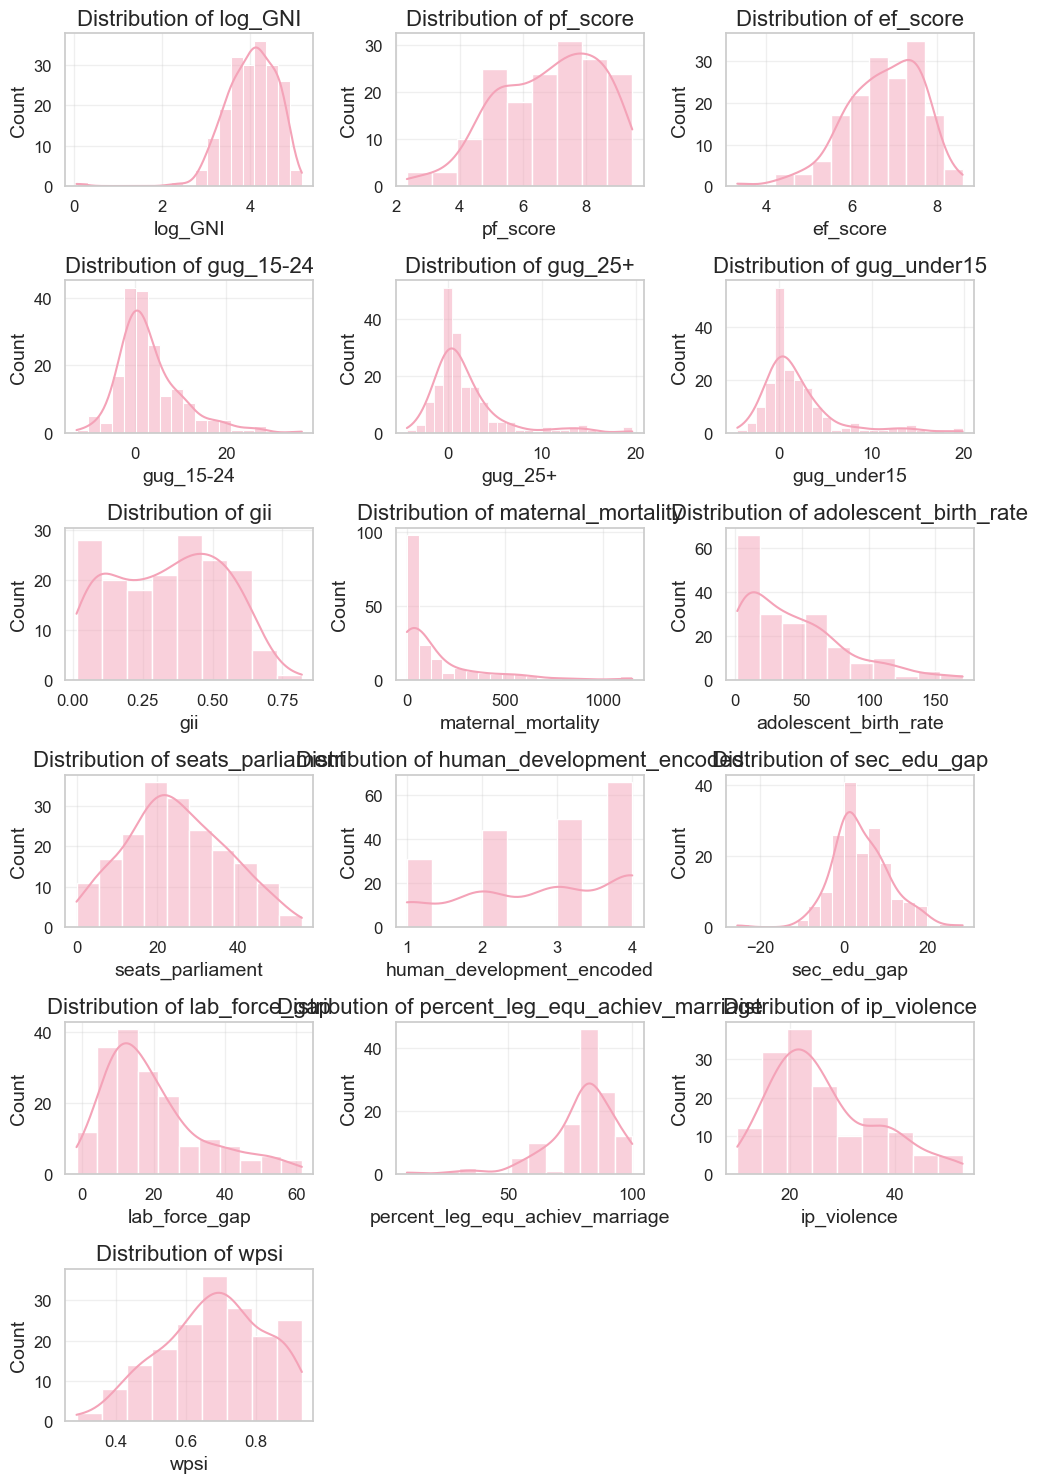

In [327]:
num_cols = global_df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(10, 15))
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols)//3 + 1, 3, i+1)
    sns.histplot(global_df[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

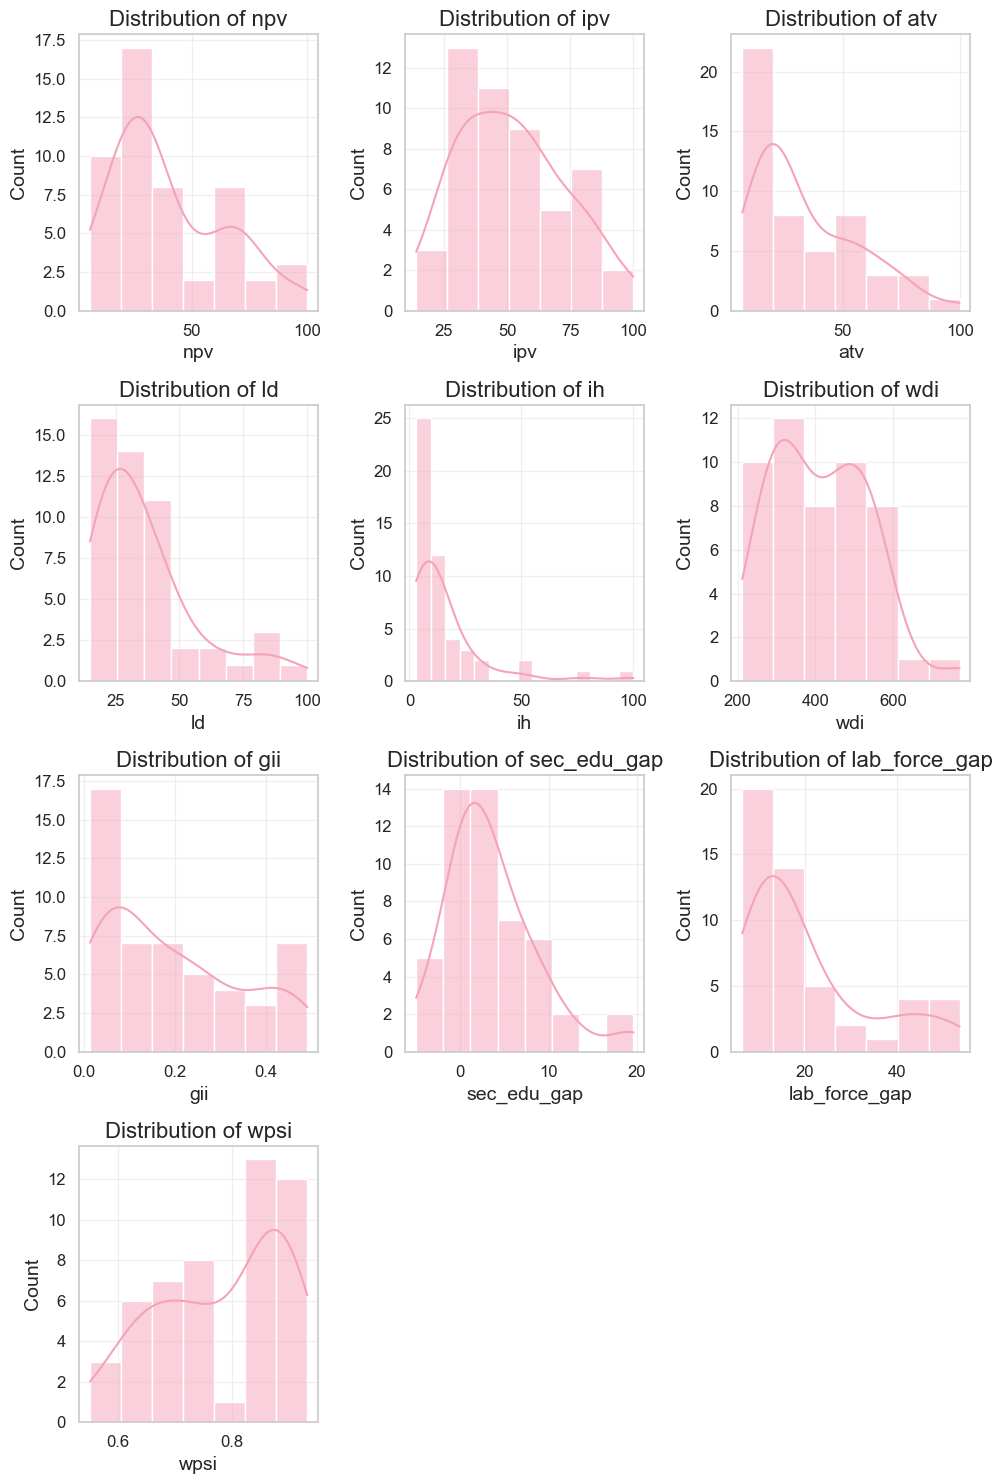

In [328]:
num_cols = violence_df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(10,15))
for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols)//3 + 1, 3, i+1)
    sns.histplot(violence_df[col], kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

### 5.2 Correlation Matrix

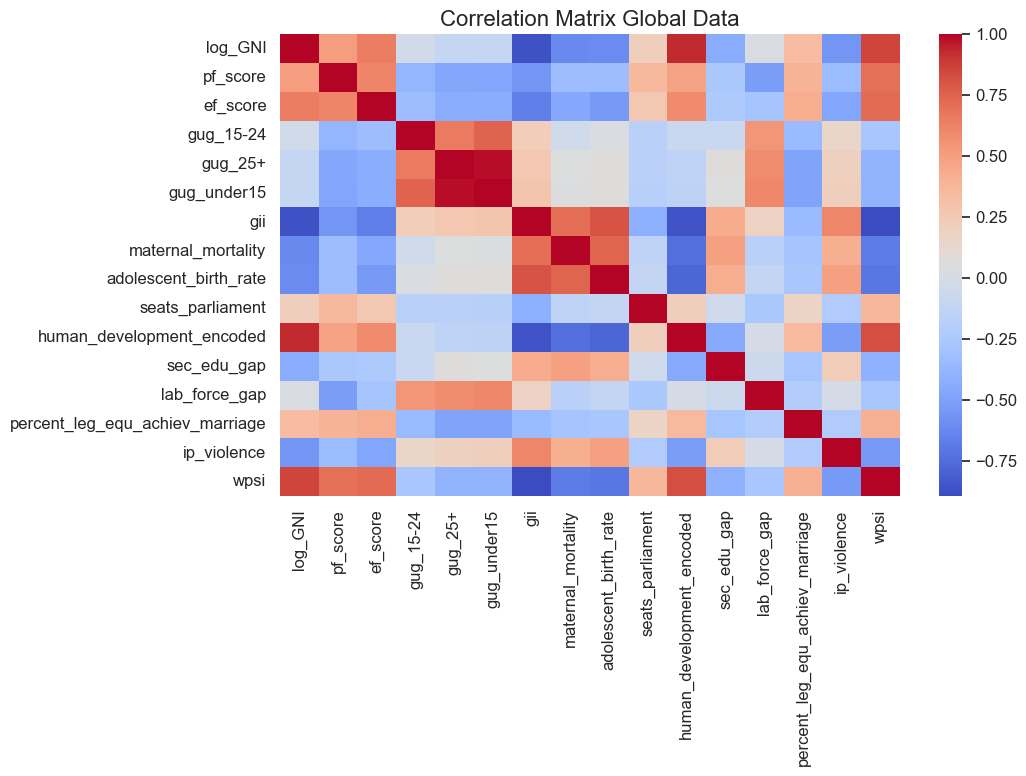

In [329]:
plt.figure(figsize=(10, 6))
corr = global_df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Matrix Global Data")
plt.show()

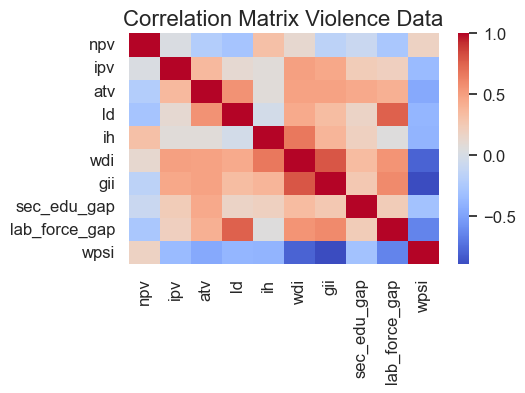

In [330]:
# correlation matrix violence data 
plt.figure(figsize=(5,3))
corr = violence_df.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Matrix Violence Data")
plt.show()

In [331]:
# top correlation with GII
target = "gii"

corr_with_gii = (
    global_df.corr(numeric_only=True)[target]
    .sort_values(ascending=False)
)

corr_with_gii

gii                                1.00
adolescent_birth_rate              0.80
maternal_mortality                 0.71
ip_violence                        0.61
sec_edu_gap                        0.44
gug_under15                        0.29
gug_25+                            0.27
gug_15-24                          0.23
lab_force_gap                      0.18
percent_leg_equ_achiev_marriage   -0.35
seats_parliament                  -0.42
pf_score                          -0.56
ef_score                          -0.67
human_development_encoded         -0.86
log_GNI                           -0.87
wpsi                              -0.89
Name: gii, dtype: float64

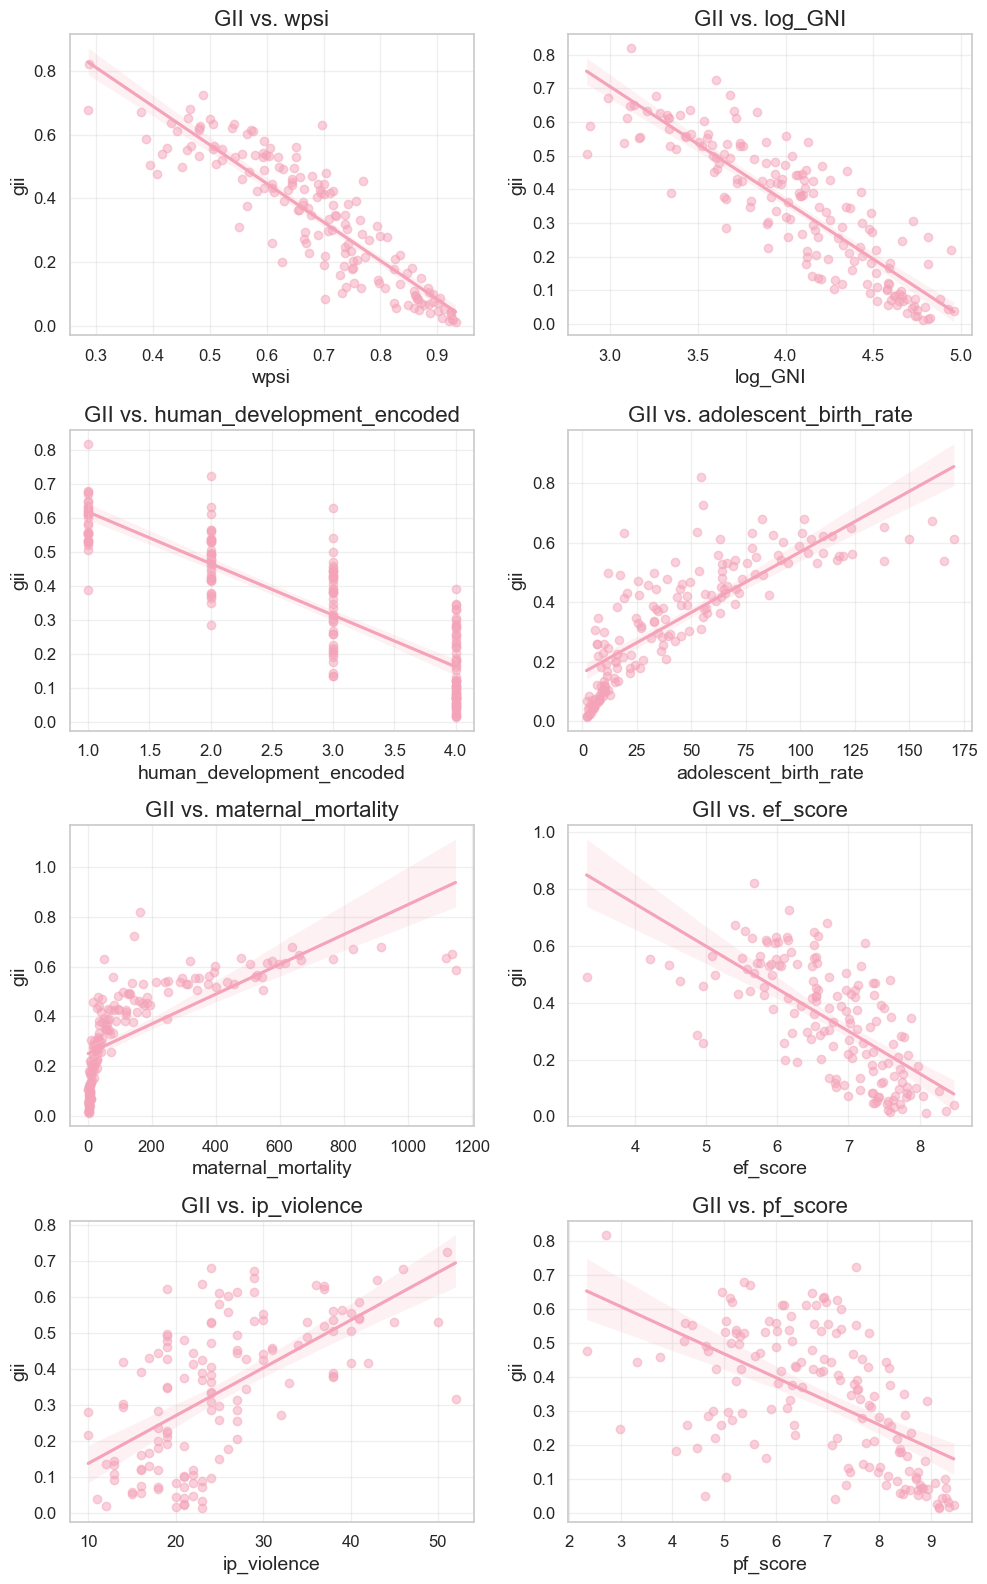

In [332]:
strongest = corr_with_gii.drop(target).abs().sort_values(ascending=False).head(8).index

plt.figure(figsize=(10, 16))

for i, col in enumerate(strongest):
    plt.subplot(4, 2, i+1)
    sns.regplot(data=global_df, x=col, y=target, scatter_kws={"alpha":0.5})
    plt.title(f"GII vs. {col}")
plt.tight_layout()
plt.show()

In [333]:
# top correlation with IPV
target = "ipv"

corr_with_ipv = (
    violence_df.corr(numeric_only=True)[target]
    .sort_values(ascending=False)
)

corr_with_ipv

ipv              1.00
wdi              0.49
gii              0.45
atv              0.36
sec_edu_gap      0.23
lab_force_gap    0.20
ld               0.11
ih               0.08
npv              0.03
wpsi            -0.35
Name: ipv, dtype: float64

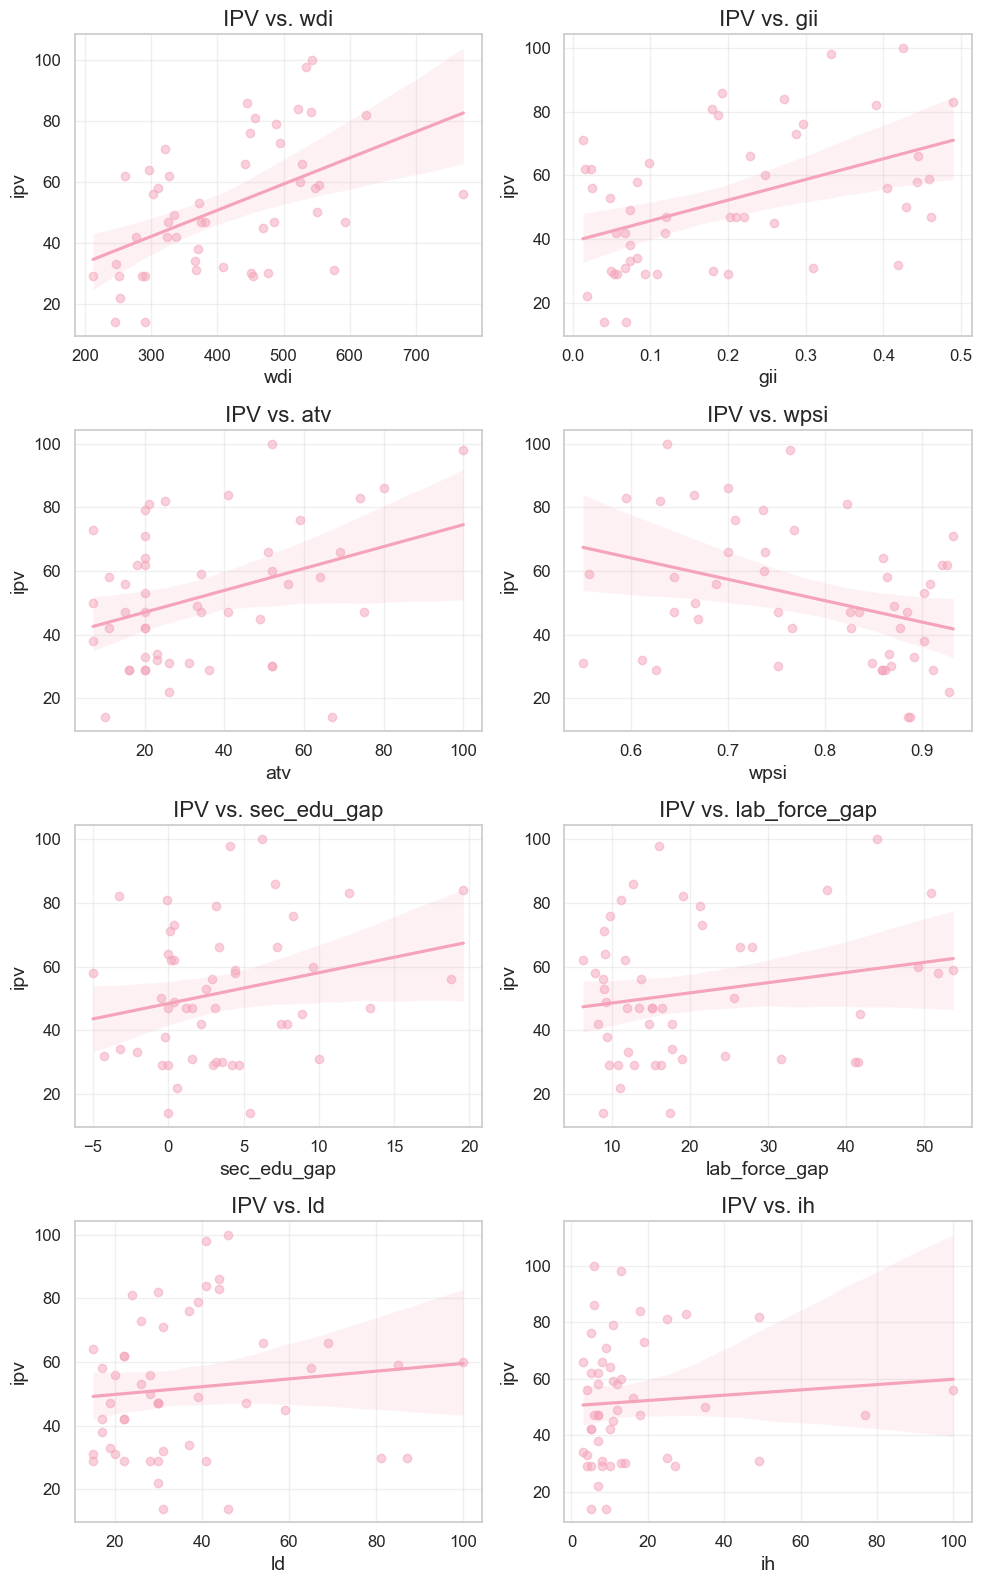

In [334]:
strongest = corr_with_ipv.drop(target).abs().sort_values(ascending=False).head(8).index

plt.figure(figsize=(10, 16))

for i, col in enumerate(strongest):
    plt.subplot(4, 2, i+1)
    sns.regplot(data=violence_df, x=col, y=target, scatter_kws={"alpha":0.5})
    plt.title(f"IPV vs. {col}")
plt.tight_layout()
plt.show()

### 5.3 Save


In [335]:
individual_df.to_csv(FEATENG_DIR / "individual_df.csv", index=False)
violence_df.to_csv(FEATENG_DIR / "violence_df.csv", index=False)
global_df.to_csv(FEATENG_DIR / "global_df.csv", index=False)